In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from pymc_marketing.mmm.delayed_saturated_mmm import (
    MMM,
    GeometricAdstock,
    LogisticSaturation,
)
from pymc_marketing.paths import data_dir
from pymc_marketing.prior import Prior

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"


%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

In [3]:
data_path = data_dir / "mmm_example.csv"

data_df = pd.read_csv(data_path, parse_dates=["date_week"])

data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_week  179 non-null    datetime64[ns]
 1   y          179 non-null    float64       
 2   x1         179 non-null    float64       
 3   x2         179 non-null    float64       
 4   event_1    179 non-null    float64       
 5   event_2    179 non-null    float64       
 6   dayofyear  179 non-null    int64         
 7   t          179 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 11.3 KB


In [4]:
def compute_sigma_from_costs(
    X: pd.DataFrame, channel_columns: list[str]
) -> list[float]:
    n_channels = len(channel_columns)
    total_spend_per_channel = X[channel_columns].sum(axis=0)
    spend_share = total_spend_per_channel / total_spend_per_channel.sum()
    prior_sigma = n_channels * spend_share.to_numpy()
    return prior_sigma.tolist()


def get_mmm(X: pd.DataFrame, channel_columns: list[str]) -> MMM:
    prior_sigma = compute_sigma_from_costs(X, channel_columns)

    model_config = {
        "saturation_beta": Prior("HalfNormal", sigma=prior_sigma, dims="channel"),
    }

    return MMM(
        adstock=GeometricAdstock(l_max=8),
        saturation=LogisticSaturation(),
        date_column="date_week",
        channel_columns=channel_columns,
        control_columns=[
            "event_1",
            "event_2",
            "t",
        ],
        yearly_seasonality=2,
        model_config=model_config,
    )


def fit_mmm(
    mmm: MMM, X: pd.DataFrame, y: pd.Series, random_seed: np.random.Generator
) -> MMM:
    fit_kwargs = {
        "tune": 1_000,
        "chains": 4,
        "draws": 2_000,
        "nuts_sampler": "numpyro",
        "target_accept": 0.9,
        "random_seed": random_seed,
    }
    _ = mmm.fit(X, y, progressbar=False, **fit_kwargs)
    _ = mmm.sample_posterior_predictive(
        X, extend_idata=True, combined=True, progressbar=False, random_seed=random_seed
    )
    return mmm

In [5]:
X = data_df[["date_week", "x1", "x2", "event_1", "event_2", "t"]]
y = data_df["y"]

In [6]:
n_init = 158
forecast_horizon = 12
n_iterations = y.size - n_init - forecast_horizon + 1

In [7]:
from dataclasses import dataclass


@dataclass
class TimeSliceCrossValidation:
    """Container for the results of the time slice cross validation."""

    X_train: pd.DataFrame
    y_train: pd.Series
    X_test: pd.DataFrame
    y_test: pd.Series
    mmm: MMM
    y_pred_test: pd.Series

In [8]:
results = []


for iteration in tqdm(range(n_iterations)):
    # Split data into train and test
    X_train = X.iloc[: iteration + n_init]
    y_train = y.iloc[: iteration + n_init]
    X_test = X.iloc[iteration + n_init : iteration + n_init + forecast_horizon]
    y_test = y.iloc[iteration + n_init : iteration + n_init + forecast_horizon]

    # Fit model
    mmm = get_mmm(X_train, ["x1", "x2"])
    mmm = fit_mmm(mmm, X_train, y_train, rng)

    y_pred_test = mmm.sample_posterior_predictive(
        X_pred=X_test, include_last_observations=True, extend_idata=False
    )

    results.append(
        TimeSliceCrossValidation(
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            mmm=mmm,
            y_pred_test=y_pred_test,
        )
    )

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Sampling: [y]
Sampling: [y]


Output()

 10%|█         | 1/10 [00:20<03:00, 20.03s/it]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Sampling: [y]
Sampling: [y]


Output()

 20%|██        | 2/10 [00:38<02:35, 19.39s/it]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Sampling: [y]
Sampling: [y]


Output()

 30%|███       | 3/10 [00:57<02:11, 18.79s/it]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Sampling: [y]
Sampling: [y]


Output()

 40%|████      | 4/10 [01:16<01:55, 19.24s/it]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Sampling: [y]
Sampling: [y]


Output()

 50%|█████     | 5/10 [01:36<01:36, 19.38s/it]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Sampling: [y]
Sampling: [y]


Output()

 60%|██████    | 6/10 [01:56<01:18, 19.56s/it]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Sampling: [y]
Sampling: [y]


Output()

 70%|███████   | 7/10 [02:17<01:00, 20.11s/it]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Sampling: [y]
Sampling: [y]


Output()

 80%|████████  | 8/10 [02:38<00:40, 20.23s/it]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Sampling: [y]
Sampling: [y]


Output()

 90%|█████████ | 9/10 [02:58<00:20, 20.27s/it]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Sampling: [y]
Sampling: [y]


Output()

100%|██████████| 10/10 [03:19<00:00, 19.97s/it]


/var/folders/p5/ndc9d2b90_x9vnt8nzzygcb00000gp/T/ipykernel_57289/3044778377.py:16: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  test_hdi = az.hdi(result.y_pred_test["y"].to_numpy().T)
/var/folders/p5/ndc9d2b90_x9vnt8nzzygcb00000gp/T/ipykernel_57289/3044778377.py:16: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  test_hdi = az.hdi(result.y_pred_test["y"].to_numpy().T)
/var/folders/p5/ndc9d2b90_x9vnt8nzzygcb00000gp/T/ipykernel_57289/3044778377.py:16: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  test_hdi = az.hdi(result.y_pred_test["y"].to_numpy().T)
/var/folders/p5/ndc9d2b90_x9vnt8nzzygcb00000gp/T/ipykernel_57289/3044778377.py:16: FutureWarning: hdi c

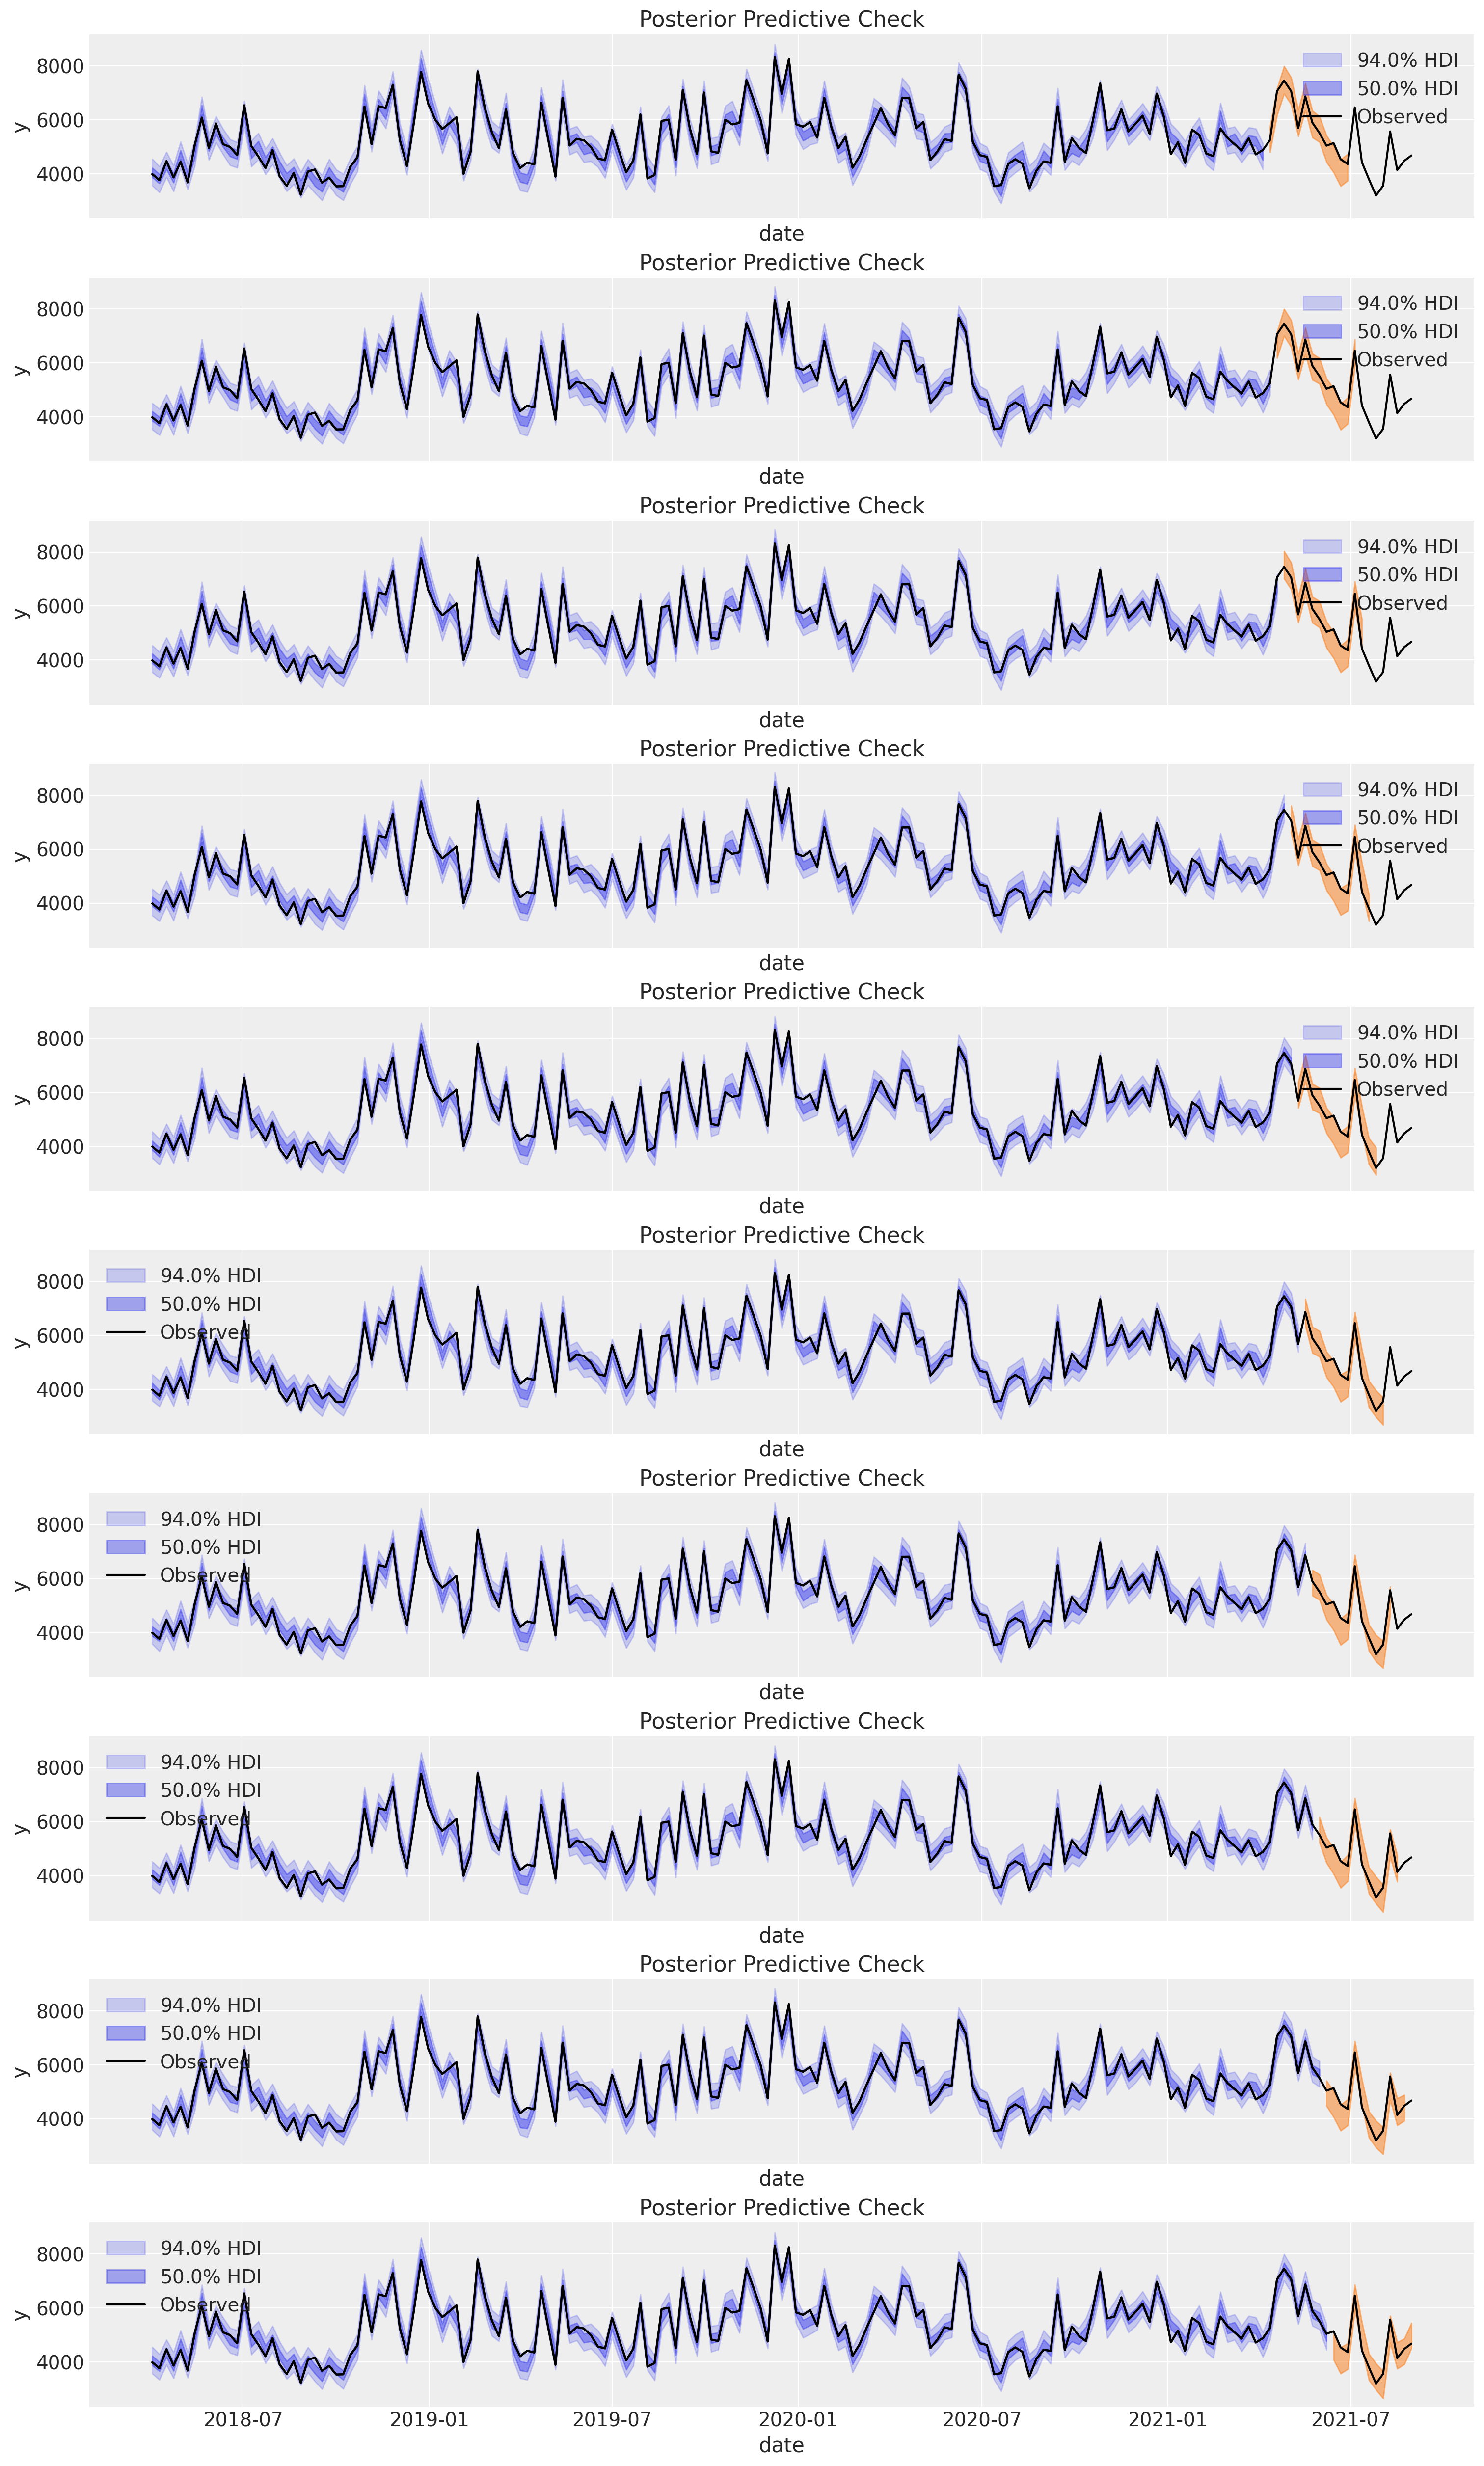

In [53]:
fig, axes = plt.subplots(
    nrows=n_iterations,
    ncols=1,
    figsize=(15, 25),
    sharex=True,
    sharey=True,
    layout="constrained",
)

axes = axes.ravel()

for i, result in enumerate(results):
    ax = axes[i]
    result.mmm.plot_posterior_predictive(original_scale=True, ax=ax)

    test_hdi = az.hdi(result.y_pred_test["y"].to_numpy().T)

    ax.fill_between(
        result.X_test["date_week"],
        test_hdi[:, 0],
        test_hdi[:, 1],
        color="C1",
        alpha=0.5,
    )
    ax.plot(X["date_week"], y, color="black")